In [1]:
import os
import re

import numpy as np
import pandas as pd
import flexmatcher
import Levenshtein

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
if not os.path.exists('data/'):
    os.mkdir('data')
    pd.read_csv('../Project/scrape_results/imdb_master.csv').to_csv('data/imdb_movie.csv')
    tomato_movie = pd.read_csv('../Project/scrape_results/tomato_master.csv')
    for word_num in range(1, 6):
        col_name = f'review_word_{word_num}'
        tomato_movie[col_name] = tomato_movie[col_name].replace(to_replace=list('12345'), value='')
    tomato_movie.to_csv('data/tomato_movie.csv')

# Part A: 


## Process datasets

In [3]:
imdb_movie = pd.read_csv('data/imdb_movie.csv').drop(columns=['Unnamed: 0'])
tomato_movie = pd.read_csv('data/tomato_movie.csv').drop(columns=['Unnamed: 0'])

---
### Process imdb movie data 

In [4]:
# we can see that there are no duplicated values
imdb_movie.duplicated().value_counts()

False    1000
dtype: int64

In [5]:
# However there are significant missing values in box gross
imdb_movie.isna().sum()

rank               0
title              0
year               0
genre              0
rating_score       0
rating_count       0
box gross        190
review_word_1      0
review_word_2      0
review_word_3      0
review_word_4      0
review_word_5      0
dtype: int64

In [6]:
# filling these values with median is very odd. However this is probably the only thing we can do 
# we do not have enough data to make prediction using linear regression to fill missing value 
# we also have the wrong data types to use KNN to fill missing vlaue 
imdb_movie['box gross'].fillna(value=imdb_movie['box gross'].median(), inplace=True)

In [7]:
imdb_movie.isna().sum()

rank             0
title            0
year             0
genre            0
rating_score     0
rating_count     0
box gross        0
review_word_1    0
review_word_2    0
review_word_3    0
review_word_4    0
review_word_5    0
dtype: int64

---
### Process tomato movie data

In [8]:
# same here, there is no duplicate, however we have significantly less rows compare to imdb_movie
tomato_movie.duplicated().value_counts()

False    511
dtype: int64

In [9]:
tomato_movie.isna().sum()

rank               0
title              0
year               0
genre            101
user_rating       94
rating_count      96
us_gross_box     242
review_word_1    100
review_word_2    100
review_word_3    100
review_word_4    100
review_word_5    100
dtype: int64

#### Fill missing value in genre

In [10]:
# there are quite a lot of missing values, but we can borrow some from imdb_movie to fill. 
# for example, genre should be the same regardless of what website said movie is listed on 
for row_index, series in tomato_movie.loc[tomato_movie['genre'].isna()].iterrows():
    imdb_match = imdb_movie.loc[imdb_movie['title'] == series['title']]
    if len(imdb_match):
        tomato_movie.at[row_index, 'genre'] = imdb_match['genre'].to_list()[0]

In [11]:
# now that we have get ride of all the NA in genre
# however, user_rating and movie_count remains a big issue
tomato_movie.isna().sum()

rank               0
title              0
year               0
genre              0
user_rating       94
rating_count      96
us_gross_box     242
review_word_1    100
review_word_2    100
review_word_3    100
review_word_4    100
review_word_5    100
dtype: int64

#### Find best approach to fill user_rating

In [12]:
# lets make a copy of the DF with only valid user_rating and rating_count 
# to see if we can use a linear regression with user_rating = weight*rank + bias to fill user_rating
# as discussed, we can't use KNN to fill anything
valid_tomato_movie = tomato_movie.loc[tomato_movie['user_rating'].notna() & tomato_movie['rating_count'].notna()]

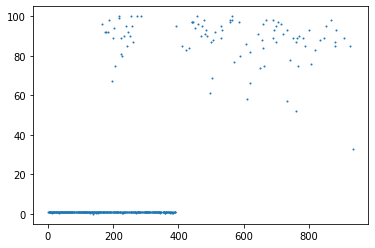

In [13]:
# observe that there are some weird values. This is probably caused by mis-parsed string when scraping. 
plt.scatter(valid_tomato_movie['rank'], valid_tomato_movie['user_rating'], s=1)

In [14]:
# lets try to fix that issue by converting values larger than 1 into float 
def make_percentage(value):
    return value/100 if value > 1 else value 

<AxesSubplot:xlabel='rank', ylabel='user_rating'>

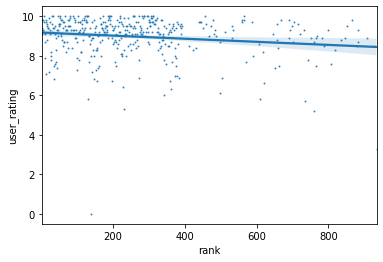

In [15]:
# even though we converted the values into float, this is not even close to a valid linear regression line
valid_tomato_movie['user_rating'] = valid_tomato_movie['user_rating'].map(make_percentage) * 10
sns.regplot(valid_tomato_movie['rank'], valid_tomato_movie['user_rating'], scatter_kws={'s':1})

#### Find best approach to fill rating_count

<AxesSubplot:xlabel='rank', ylabel='rating_count'>

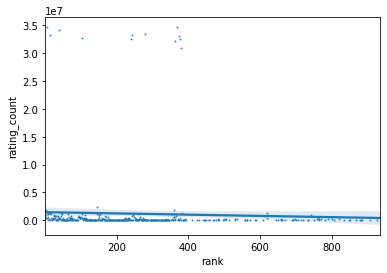

In [16]:
# same here with rating_count. the outlier is causing too much trouble
sns.regplot(valid_tomato_movie['rank'], valid_tomato_movie['rating_count'], scatter_kws={'s':1})

<AxesSubplot:xlabel='rank', ylabel='rating_count'>

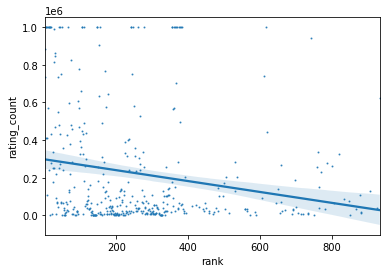

In [17]:
# but even if you clip it, the regression is still not coherent 
sns.regplot(valid_tomato_movie['rank'], valid_tomato_movie['rating_count'].clip(0, 1e6), scatter_kws={'s':1})

#### Just use median 

In [18]:
# right now, the best way to fill user_rating and rating_count is to use median
tomato_movie['user_rating'] = tomato_movie['user_rating'].map(make_percentage, na_action='ignore') * 10

tomato_movie['user_rating'].fillna(value=tomato_movie['user_rating'].median(), inplace=True)
tomato_movie['rating_count'].fillna(value=tomato_movie['rating_count'].median(), inplace=True)

#### How avout us_box_gross and missing words? 

In [19]:
# now we have arrived the point where we need to think about box gross and words 
tomato_movie.isna().sum()

rank               0
title              0
year               0
genre              0
user_rating        0
rating_count       0
us_gross_box     242
review_word_1    100
review_word_2    100
review_word_3    100
review_word_4    100
review_word_5    100
dtype: int64

In [20]:
# observe that this is all in string
tomato_movie['us_gross_box'].value_counts()

$2.0M      5
$1.2M      4
$1.8M      3
$1.3M      3
$1.6M      3
          ..
$5.0M      1
$162.8M    1
$56.1M     1
$5.8M      1
$100.4M    1
Name: us_gross_box, Length: 233, dtype: int64

In [21]:
# which means we need to do some conversion. 
# and before we do that, lets check what units do we have
unit_regex = re.compile(r'\d*([a-zA-Z]*)$')
set([unit_regex.search(item).group(1) for item in tomato_movie['us_gross_box'].unique() if isinstance(item, str)])

{'', 'K', 'M'}

In [22]:
from string import digits

float_chars = digits + '.'

In [23]:
# it appears that not only do we have thousands and millions, there are some without values
# the ones without values might be errors during scrapign process
multiply_dict = {'': 1, 'K': 1_000, 'M': 1_000_000}

def convert_into_digits(value):
    float_value = float(''.join([char for char in value if char in float_chars]))
    return float_value * multiply_dict[unit_regex.search(value).group(1)]

In [24]:
# now we can convert everything into float 
tomato_movie['us_gross_box'] = tomato_movie['us_gross_box'].map(convert_into_digits, na_action='ignore')
tomato_movie['us_gross_box'].dtype

dtype('float64')

<AxesSubplot:xlabel='rank', ylabel='us_gross_box'>

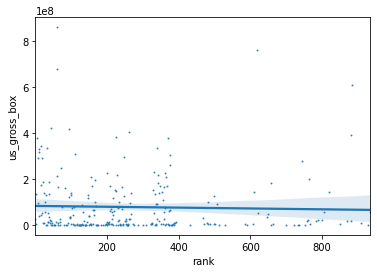

In [25]:
# same logic here, we determined that it's best if we use median 
valid_tomato_movie = tomato_movie.loc[tomato_movie['us_gross_box'].notna()]
sns.regplot(valid_tomato_movie['rank'], valid_tomato_movie['us_gross_box'], scatter_kws={'s':1})

In [26]:
tomato_movie['us_gross_box'].fillna(value=tomato_movie['us_gross_box'].median(), inplace=True)

In [27]:
# The only thing we can do about word is to use '' 
for word_num in range(1, 6): 
    tomato_movie[f'review_word_{word_num}'].fillna(value='', inplace=True)

In [28]:
# now that we have filed everything 
tomato_movie.isna().sum()

rank             0
title            0
year             0
genre            0
user_rating      0
rating_count     0
us_gross_box     0
review_word_1    0
review_word_2    0
review_word_3    0
review_word_4    0
review_word_5    0
dtype: int64

### Align data types

In [29]:
for col_name in imdb_movie.columns:
    imdb_movie[col_name] = imdb_movie[col_name].astype(str)
for col_name in tomato_movie.columns:
    tomato_movie[col_name] = tomato_movie[col_name].astype(str)

In [30]:
imdb_movie.dtypes

rank             object
title            object
year             object
genre            object
rating_score     object
rating_count     object
box gross        object
review_word_1    object
review_word_2    object
review_word_3    object
review_word_4    object
review_word_5    object
dtype: object

In [31]:
tomato_movie.dtypes

rank             object
title            object
year             object
genre            object
user_rating      object
rating_count     object
us_gross_box     object
review_word_1    object
review_word_2    object
review_word_3    object
review_word_4    object
review_word_5    object
dtype: object

----
### Inspect dataset

In [32]:
imdb_movie.head(5)

,rank,title,year,genre,rating_score,rating_count,box gross,review_word_1,review_word_2,review_word_3,review_word_4,review_word_5
0,1,The Shawshank Redemption,1994,Drama,9.3,2297303,28699976.0,shawshank,andy,prison,life,redemption
1,2,The Godfather,1972,"Crime, Drama",9.2,1585716,134966411.0,godfather,ever,seen,vito,first
2,3,The Dark Knight,2008,"Action, Crime, Drama",9.0,2261605,535234033.0,dark,helpful,confidently,directed,brooding
3,4,The Godfather: Part II,1974,"Crime, Drama",9.0,1107765,47834595.0,michael,coppola,first,pacino,family
4,5,The Lord of the Rings: The Return of the King,2003,"Action, Adventure, Drama",8.9,1615048,377845905.0,rings,still,back,best,helpful


In [33]:
tomato_movie.head(5)

,rank,title,year,genre,user_rating,rating_count,us_gross_box,review_word_1,review_word_2,review_word_3,review_word_4,review_word_5
0,1,The Shawshank Redemption,1994,drama,9.1,886475.0,27300000.0,time,story,best,ever,greatest
1,2,The Godfather,1972,"crime, drama",9.8,733925.0,134800000.0,godfather,time,never,cinematography,great
2,3,The Dark Knight,2008,"action, adventure, fantasy",9.399999999999999,1831566.0,2000000.0,best,batman,ledger,heath,joker
3,4,The Godfather: Part II,1974,"crime, drama",9.8,411452.0,17700000.0,godfather,michael,part,first,sequel
4,5,The Lord of the Rings: The Return of the King,2003,"adventure, fantasy",9.3,34679773.0,377800000.0,epic,trilogy,story,final,characters


The column names reflect what the column contains
    
    - rating_score and user_rating are both crowd rating for movie 
    - box gross and us_gross_box are movie ticket sales in the US 
    - review_word 1-5 are top 5 words that occured in first 100 user reviews for each movie 

---
## Schema matching

In [34]:
def jaccard_score(list1, list2): 
    set1, set2 = set(list1), set(list2)
    return round(len(set1.intersection(set2)) / len(set1.union(set2)), 2)

def n_gram(query, n_length=3):
    query = '$' * (n_length-1) + query + '$' * (n_length-1)
    return [query[index-(n_length-1):index+1] for index in range(2, len(query))]

def col_jaccard(column1, column2, n_length=3):
    col2_n_gram = [n_gram(item, n_length) for item in column2.tolist()]
    result = []
    for col1_item in [n_gram(item, n_length) for item in column1.tolist()]:
        max_instance_score = max([jaccard_score(col1_item, col2_item) for col2_item in col2_n_gram])
        result.append(max_instance_score)
    return round(np.mean(result), 2)

### Instance matching

In [35]:
for n_length in [2,3,4]:
    print(f'\n{"-"*50}\nresult for n_length of {n_length}')
    for col_name in imdb_movie.columns:
        score_list = [(col_name_2, col_jaccard(imdb_movie[col_name], tomato_movie[col_name_2], n_length)) for col_name_2 in tomato_movie.columns]
        score_list.sort(key=lambda item: item[-1], reverse=True)
        [print(f'mean instance Jaccard score {col_name} vs. {col_name_2} is: {score}') for col_name_2, score in score_list[:2]]
        print()


--------------------------------------------------
result for n_length of 2
mean instance Jaccard score rank vs. rank is: 0.83
mean instance Jaccard score rank vs. year is: 0.42

mean instance Jaccard score title vs. title is: 0.65
mean instance Jaccard score title vs. review_word_1 is: 0.22

mean instance Jaccard score year vs. year is: 0.99
mean instance Jaccard score year vs. rank is: 0.61

mean instance Jaccard score genre vs. genre is: 0.87
mean instance Jaccard score genre vs. review_word_4 is: 0.33

mean instance Jaccard score rating_score vs. user_rating is: 0.84
mean instance Jaccard score rating_score vs. rank is: 0.32

mean instance Jaccard score rating_count vs. rank is: 0.46
mean instance Jaccard score rating_count vs. year is: 0.3

mean instance Jaccard score box gross vs. rating_count is: 0.48
mean instance Jaccard score box gross vs. us_gross_box is: 0.45

mean instance Jaccard score review_word_1 vs. review_word_1 is: 0.54
mean instance Jaccard score review_word_1 vs.

#### Explanations: 
    
    - instance matching takes a long time, and produce mediocre result 
    - the overall complexity is O(c1 * c2 * r1 * r2 ), where c1, c2 are column numbers of table1 and table2; r1, r2 are row numbers of table1 and table2, respectively 
    - rank, title, year, genre, rating_score and review_word_1 can be matched using n_gram-jaccard score, but not the rest
    - rating_score have relatively stable range (from 0 to 10), thus can be matched with n_gram jaccard 
    - rating_count are all integers, but all the values are unique from column to column and have a large range. Euclidean distance can better approximate distance beterrn numeric columns 
    - box gross can be matched to us_gross_box, but very unstable and only by a slight margin comapred to rating_count 
    - jaccard cannot confidently match box gross and us_gross_box, but Euclidean should be able to do that
    - review_word 1-5 are strings values, and is suitable to use jaccard, however if we scrape 10k user reviews and count them, the result will be better on jaccard score comapre to score. Current sample size (100) is not large enough to stablize the word count results

---
### Name matching

In [36]:
for col_name1 in imdb_movie.columns:
    score_list = [(col_name_2, jaccard_score(n_gram(col_name1), n_gram(col_name_2))) for col_name_2 in tomato_movie.columns]
    score_list.sort(key=lambda item: item[-1], reverse=True)
    [print(f'Jaccard score {col_name1} vs. {col_name_2} is: {score}') for col_name_2, score in score_list[:2]]
    print()

Jaccard score rank vs. rank is: 1.0
Jaccard score rank vs. rating_count is: 0.11

Jaccard score title vs. title is: 1.0
Jaccard score title vs. genre is: 0.08

Jaccard score year vs. year is: 1.0
Jaccard score year vs. rank is: 0.0

Jaccard score genre vs. genre is: 1.0
Jaccard score genre vs. title is: 0.08

Jaccard score rating_score vs. rating_count is: 0.33
Jaccard score rating_score vs. user_rating is: 0.17

Jaccard score rating_count vs. rating_count is: 1.0
Jaccard score rating_count vs. user_rating is: 0.17

Jaccard score box gross vs. us_gross_box is: 0.19
Jaccard score box gross vs. rank is: 0.0

Jaccard score review_word_1 vs. review_word_1 is: 1.0
Jaccard score review_word_1 vs. review_word_2 is: 0.67

Jaccard score review_word_2 vs. review_word_2 is: 1.0
Jaccard score review_word_2 vs. review_word_1 is: 0.67

Jaccard score review_word_3 vs. review_word_3 is: 1.0
Jaccard score review_word_3 vs. review_word_1 is: 0.67

Jaccard score review_word_4 vs. review_word_4 is: 1.0
Ja

In [37]:
for col_name1 in imdb_movie.columns:
    score_list = [(col_name_2, Levenshtein.distance(col_name1, col_name_2)) for col_name_2 in tomato_movie.columns]
    score_list.sort(key=lambda item: item[-1])
    [print(f'Levenshtein score {col_name1} vs. {col_name_2} is: {score}') for col_name_2, score in score_list[:2]]
    print()

Levenshtein score rank vs. rank is: 0
Levenshtein score rank vs. year is: 4

Levenshtein score title vs. title is: 0
Levenshtein score title vs. genre is: 4

Levenshtein score year vs. year is: 0
Levenshtein score year vs. genre is: 3

Levenshtein score genre vs. genre is: 0
Levenshtein score genre vs. year is: 3

Levenshtein score rating_score vs. rating_count is: 4
Levenshtein score rating_score vs. rank is: 9

Levenshtein score rating_count vs. rating_count is: 0
Levenshtein score rating_count vs. rank is: 9

Levenshtein score box gross vs. rank is: 8
Levenshtein score box gross vs. year is: 8

Levenshtein score review_word_1 vs. review_word_1 is: 0
Levenshtein score review_word_1 vs. review_word_2 is: 1

Levenshtein score review_word_2 vs. review_word_2 is: 0
Levenshtein score review_word_2 vs. review_word_1 is: 1

Levenshtein score review_word_3 vs. review_word_3 is: 0
Levenshtein score review_word_3 vs. review_word_1 is: 1

Levenshtein score review_word_4 vs. review_word_4 is: 0


#### Explanations: 

    - rating_score vs user_rating, box gross vs us_gross_box are what we want to match 
    - observe that n_gram-jaccard performed slightly better compared to levenshtein. 
    - levenshtein only considers edit distance, where sematic meaning does not matter 
    - n_gram-jaccard at least account for same character pattern within words

---
# Part B: 

In [38]:
april_data = pd.read_csv('data/04-15-2020.csv')
september_data = pd.read_csv('data/09-15-2020.csv')

---
## Inspect

In [39]:
april_data.shape

(3026, 12)

In [40]:
april_data.duplicated().sum()

0

In [41]:
september_data.shape

(3954, 14)

In [42]:
september_data.duplicated().sum()

0

## FlexMatcher for third dataset

In [43]:
time_series_data = pd.read_csv('data/time_series_covid19_confirmed_US.csv')

In [44]:
time_series_data.head(2)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,2197,2212,2230,2242,2267,2283,2304,2328,2351,2385
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,6995,7061,7097,7134,7188,7226,7263,7348,7409,7454


---

### Before we do anything, we need to fill NA and align data type

In [45]:
september_data.dtypes

FIPS                   float64
Admin2                  object
Province_State          object
Country_Region          object
Last_Update             object
Lat                    float64
Long_                  float64
Confirmed                int64
Deaths                   int64
Recovered                int64
Active                 float64
Combined_Key            object
Incidence_Rate         float64
Case-Fatality_Ratio    float64
dtype: object

In [46]:
na_dict = {september_data['FIPS'].dtype: 0.00, september_data['Admin2'].dtype: '', september_data['Confirmed'].dtype: 0}

for col_name in september_data.columns:
    if col_name in april_data.columns: 
        april_data[col_name].fillna(value=na_dict[april_data[col_name].dtype], inplace=True)
    if col_name in time_series_data.columns: 
        time_series_data[col_name].fillna(value=na_dict[time_series_data[col_name].dtype], inplace=True)
    september_data[col_name].fillna(value=na_dict[september_data[col_name].dtype], inplace=True)

In [47]:
[(col_name, na_count) for col_name, na_count in time_series_data.isna().sum().to_dict().items() if na_count]

[]

In [48]:
april_data.isna().sum().unique()

array([0])

In [49]:
september_data.isna().sum().unique()

array([0])

In [50]:
september_data = september_data.astype(str)
april_data = april_data.astype(str)
time_series_data = time_series_data.astype(str)

### Now we can start matching 

In [51]:
unknown_name_data = time_series_data.copy() 
unknown_name_data.columns = [str(item) for item in range(time_series_data.shape[1])]

In [52]:
unknown_name_data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,297,298,299,300,301,302,303,304,305,306
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.53952745,-86.64408227,...,2197,2212,2230,2242,2267,2283,2304,2328,2351,2385
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.72774991,-87.72207058,...,6995,7061,7097,7134,7188,7226,7263,7348,7409,7454


---
recall that april_data and september_data have different column size, but some of them are identical

we can use that directly without introducing new name 

In [53]:
april_col_mapping = {item1: item2 for item1, item2 in zip(april_data.columns, september_data.columns)}
sep_col_mapping = april_col_mapping.copy()
sep_col_mapping['Incidence_Rate'] = 'Incidence_Rate'
sep_col_mapping['Case-Fatality_Ratio'] = 'Case-Fatality_Ratio'

In [54]:
april_col_mapping

{'FIPS': 'FIPS',
 'Admin2': 'Admin2',
 'Province_State': 'Province_State',
 'Country_Region': 'Country_Region',
 'Last_Update': 'Last_Update',
 'Lat': 'Lat',
 'Long_': 'Long_',
 'Confirmed': 'Confirmed',
 'Deaths': 'Deaths',
 'Recovered': 'Recovered',
 'Active': 'Active',
 'Combined_Key': 'Combined_Key'}

In [55]:
sep_col_mapping

{'FIPS': 'FIPS',
 'Admin2': 'Admin2',
 'Province_State': 'Province_State',
 'Country_Region': 'Country_Region',
 'Last_Update': 'Last_Update',
 'Lat': 'Lat',
 'Long_': 'Long_',
 'Confirmed': 'Confirmed',
 'Deaths': 'Deaths',
 'Recovered': 'Recovered',
 'Active': 'Active',
 'Combined_Key': 'Combined_Key',
 'Incidence_Rate': 'Incidence_Rate',
 'Case-Fatality_Ratio': 'Case-Fatality_Ratio'}

In [56]:
col_mappings = [april_col_mapping, sep_col_mapping]
datasets = [april_data, september_data]

matcher = flexmatcher.FlexMatcher(datasets, col_mappings, sample_size=1000)
matcher.train()

Create training data ...
Training FlexMatcher ...
Training Completed ...


In [57]:
test_data = time_series_data.copy(deep=True)
test_data.columns = list(range(test_data.shape[1]))

In [58]:
predicted_mapping = matcher.make_prediction(test_data)
predicted_mapping 

{0: 'Case-Fatality_Ratio',
 2: 'Incidence_Rate',
 3: 'Confirmed',
 4: 'FIPS',
 5: 'Admin2',
 6: 'Province_State',
 7: 'Country_Region',
 8: 'Lat',
 9: 'Long_',
 10: 'Combined_Key',
 11: 'Recovered',
 79: 'Deaths',
 105: 'Active',
 247: 'Last_Update'}

In [59]:
# convert the numeric column name back into the actual column name 
{time_series_data.columns[key]: value for key, value in predicted_mapping.items()}

{'UID': 'Case-Fatality_Ratio',
 'iso3': 'Incidence_Rate',
 'code3': 'Confirmed',
 'FIPS': 'FIPS',
 'Admin2': 'Admin2',
 'Province_State': 'Province_State',
 'Country_Region': 'Country_Region',
 'Lat': 'Lat',
 'Long_': 'Long_',
 'Combined_Key': 'Combined_Key',
 '1/22/20': 'Recovered',
 '3/30/20': 'Deaths',
 '4/25/20': 'Active',
 '9/14/20': 'Last_Update'}

In [60]:
matcher.make_prediction(time_series_data)

{'UID': 'Case-Fatality_Ratio',
 'iso3': 'Incidence_Rate',
 'code3': 'Confirmed',
 'FIPS': 'FIPS',
 'Admin2': 'Admin2',
 'Province_State': 'Province_State',
 'Country_Region': 'Country_Region',
 'Lat': 'Lat',
 'Long_': 'Long_',
 'Combined_Key': 'Combined_Key',
 '1/22/20': 'Recovered',
 '3/26/20': 'Deaths',
 '4/26/20': 'Active',
 '9/23/20': 'Last_Update'}

In [61]:
matcher.make_prediction(time_series_data)

{'UID': 'Case-Fatality_Ratio',
 'iso3': 'Incidence_Rate',
 'code3': 'Confirmed',
 'FIPS': 'FIPS',
 'Admin2': 'Admin2',
 'Province_State': 'Province_State',
 'Country_Region': 'Country_Region',
 'Lat': 'Lat',
 'Long_': 'Long_',
 'Combined_Key': 'Combined_Key',
 '1/22/20': 'Recovered',
 '4/1/20': 'Deaths',
 '4/30/20': 'Active',
 '8/28/20': 'Last_Update'}

### Result Interpretation 

There are several notable observations: 

1. the prediction of some columns are very accurate, especially when string values overlap significantly. This is expected as instance matching is a part of the process 
2. when instances are all integer values from a limited range, it is difficult for FlexMatcher to accurately predict the correct mapping 
3. the length of the predicted_mapping does not match the amount of columns in test_data. 
5. observe that all the values in prediction result are unique column names from original training dataset.
4. the included keys in predicted_mapping varies from prediction to prediction. This is of utmost confusion for me when examining the prediction result. 

It is unclear why 3, 4 and 5 is observed. I tried to examine the source code to determine the reason of such behavior. the result is inconclusive, the predicted_mapping are constructed by iterating the column names of target_DF. All the column names should be included regardless of whether the prediciton result is accurate or not. Also, the uniqueness of the values in predicted_mapping should not be the reason such behavior exists. As discussed, unique column names are being used as key in dictionary and therefore should all exists. 

I am running Jupyterlab in python3.6 in WSL2 Ubuntu. However a bizzard behavior like this is unlikely to be caused by platorm incompatibility. 